In [1]:
# import libraries
import sqlalchemy
import pandas as pd
import numpy as np

from sqlalchemy import create_engine
from sqlalchemy import inspect

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [2]:
# connecting to the Database using SQLAlchemy
engine = create_engine("sqlite:///Northwind_small.sqlite")

# create an inspector object
inspector = inspect(engine)

# get names of tables in database
print(inspector.get_table_names())

['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


In [3]:
# write a quick function that prints the columns of a table and each column's type

def get_columns_info(table_name):    
    """ Function takes in table name and prints columns' names
    and datatypes """
    
    cols_list = inspector.get_columns(table_name)    
    print(f"Table Name: {table_name}\n")
    for col in cols_list:
        print(f"Name: {col['name']} \t Type: {col['type']}")

In [4]:
# calling the function to test it
get_columns_info('Product')

Table Name: Product

Name: Id 	 Type: INTEGER
Name: ProductName 	 Type: VARCHAR(8000)
Name: SupplierId 	 Type: INTEGER
Name: CategoryId 	 Type: INTEGER
Name: QuantityPerUnit 	 Type: VARCHAR(8000)
Name: UnitPrice 	 Type: DECIMAL
Name: UnitsInStock 	 Type: INTEGER
Name: UnitsOnOrder 	 Type: INTEGER
Name: ReorderLevel 	 Type: INTEGER
Name: Discontinued 	 Type: INTEGER


## 1. Question: Effect of Discount on Sales

Does discount amount have a statistical significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

In [5]:
# using the pd.read_sql_query() method to get the "OrderDetail" table only
df1 = pd.read_sql_query('''SELECT * FROM OrderDetail;''', engine)

In [6]:
print('1. Rows and Columns:')
print(df1.shape)
print('...............................')
print('\n2. Info:')
print(df1.info())
print('...............................\n\n3. Dataframe:')
df1.head()

1. Rows and Columns:
(2155, 6)
...............................

2. Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB
None
...............................

3. Dataframe:


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [7]:
df1.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [8]:
crit = (df1.Discount == 0.00) | (df1.Discount == 0.05) | (df1.Discount == 0.10) | (df1.Discount == 0.15) | (df1.Discount == 0.20) | (df1.Discount == 0.25)

df1_test = df1.loc[crit]
df1_test.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

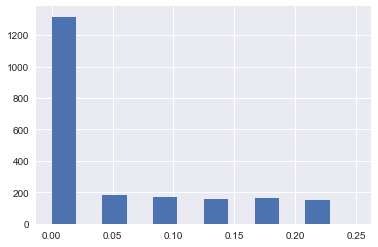

In [9]:
# plot histogram of frequency of discounts given
df1_test.Discount.hist(bins = 6, width = .02, align = 'mid', figsize=(6, 4));

Overall, most customers are not receiving any amount of discount. Of those who receive discounts, the frequency (or spread) is roughly evenly distributed.

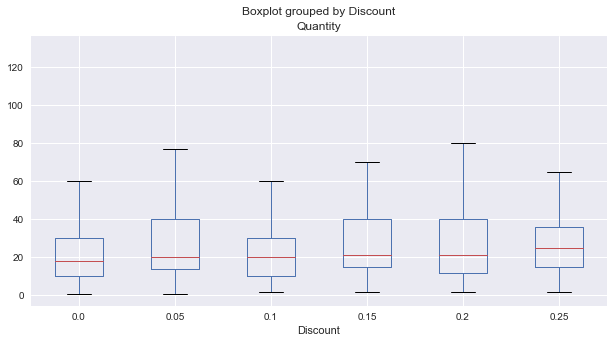

In [10]:
df1_test.boxplot('Quantity', by='Discount', figsize=(10, 5));

There seems to be no definitive relationship between discount and quantity sold amongst all discount levels. There are also no outlier with each each group.

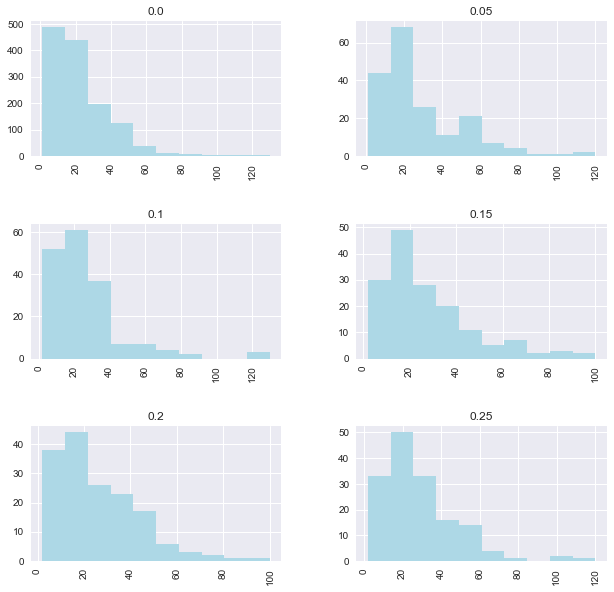

In [11]:
df1_test.hist('Quantity', by='Discount', figsize=(10, 10), color='lightblue');

### 3.2 - Hypothesis

$H_0$: The average number of products in an order is equal for all levels of discount.

> $H_0: \mu_1 = \mu_2 = \mu_3 =  ...  = \mu_i ...  = \mu_j$

$H_1$: The average number of products in an order differs between at least two levels of discount.

> $H_0: \mu_i \neq \mu_j$

I set my significance level: 

> **$\alpha$ = 0.05**

### 3.3 - Statistical Analysis

### Appropriate Test

The analysis of variance or **one-way ANOVA** is used to compare the differences between the means of two or more groups within a sample, while considering only one factor or independent variable. It can be thought of as an extension of the t-test that is used to compare the means of a condition between 2 groups. 

ANOVA is an omnibus test, meaning it tests the data as a whole. In other words, ANOVA tests if there is a difference in the mean somewhere in the model (testing if there was an overall effect), but it does not tell us where the difference is if there is one. To find out where the difference is between the groups, we have to conduct post-hoc tests. 

Although it can be thought of as an extension of the t-test in terms of when to use it, mathematically speaking it’s more of a regression model and is considered a generalized linear model (GLM).

The test statistic F follows an **F-distribution with $q$ - 1 degrees of freedom**, with $q$ being the number of groups. 

Because of the F-distribution's shape, the significance level is always specified on the right (no one-tailed or two-tailed specification is necessary).

### ANOVA Assumptions

There are 3 assumptions that need to be met for the results of an ANOVA test to be considered accurate and trustworthy. It’s important to note that **two assumptions apply to the residuals** and not the variables themselves. The ANOVA assumptions are the same as those for linear regression, and are:


* **Normality** <br> The caveat to this is that if group sizes are equal, the F-statistic is robust to violations of normality.
    
* **Homogeneity of variance** <br> Same caveat as above; if group sizes are equal, the F-statistic is robust to this violation.

* **Independent observations**

If possible, it is best to have equal-sized groups so corrections to the data do not need to be made. Fortunately, we are dealing with equal-sized groups here.

As two of the assumptions apply to the residuals, they are tested after conducting the ANOVA. The independence of observations can be assumed!

### Test Statistic

In [12]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# syntax for defining the ANOVA-model
anova = ols('Quantity ~ Discount', data=df1_test).fit()
table = sm.stats.anova_lm(anova, typ=2)
table

,sum_sq,df,F,PR(>F)
Discount,12621.238965,1.0,35.487951,2.991487e-09
Residual,762866.181622,2145.0,NaN,NaN


On the left, we have our discount factor, and on the right, the probability that this factor is indeed influential. 

Values < .05 (i.e. our α) indicate rejection of the null hypothesis. **We can see that the discount factor appears to be highly influential.**

**Assumption of Homogeneity of residuals' variance:**

In [13]:
# using Levene’s test to test for equal variances between groups
from scipy import stats
stats.levene(df1_test['Quantity'][df1_test['Discount'] == 0.00],
             df1_test['Quantity'][df1_test['Discount'] == 0.05],
             df1_test['Quantity'][df1_test['Discount'] == 0.10],
             df1_test['Quantity'][df1_test['Discount'] == 0.15],
             df1_test['Quantity'][df1_test['Discount'] == 0.20],
             df1_test['Quantity'][df1_test['Discount'] == 0.25])

LeveneResult(statistic=2.9943951679841643, pvalue=0.010664285577385134)

--> Levene’s test for homogeneity of variance is significant, which indicates that the **groups don't have equal variances**. But as stated earlier, if group sizes are equal, the F-statistic is robust to this violation.

**Assumption of Normality of residuals:**

In [14]:
# using Shapiro-Wilk method
stats.shapiro(anova.resid)

(0.8587857484817505, 3.172497684277456e-40)

--> The output is not labelled, but the numbers are the test statistic value, followed by the p-value. The results from the Shapiro-Wilk test are statistically significant, which indicates that the **residuals are not normally distributed**. But same as above: if group sizes are equal, the F-statistic is robust to violation of normality.

### Effect Size

There are a few different effect sizes for an ANOVA one can use: **eta squared (η2)**, and **omega squared (ω2)**. Omega squared is considered a better measure of effect size than eta squared because it is unbiased in its calculation.

+++ Something to note: For some reason, R2 is called eta squared within the ANOVA framework, but they are the same thing. R2 is a measure of how much variance is explained by the model, and is calculated by taking the explained variance and dividing it by the total variance. +++

The following code uses the ANOVA table produced by statsmodels and appends the effect size measures of eta-squared (η2) and omega-squared (ω2).

In [15]:
def anova_effect_size(aov):       
    """ This function takes the Anova table performed with statsmodels
    and appends two effect size measures: eta-squared and omega-squared. """
    
    # mean squared
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    # eta-squared (η2) 
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    # omega-squared (ω2)
    num = (aov[:-1]['sum_sq'] - (aov[:-1]['df']*aov['mean_sq'][-1]))
    denom = (sum(aov['sum_sq']) + aov['mean_sq'][-1])
    aov['omega_sq'] = num / denom    
    
    return aov

anova_effect_size(table)

,sum_sq,df,F,PR(>F),mean_sq,eta_sq,omega_sq
Discount,12621.238965,1.0,35.487951,2.991487e-09,12621.238965,0.016275,0.015809
Residual,762866.181622,2145.0,NaN,NaN,355.648570,NaN,NaN


According to both measures (around 0.016), the discount only has a **small effect**.

### Post-hoc Testing

The overall model was significant, now we want to know **which groups actually differ**. 

Tukey’s HSD is one method that can be used. The Tukey HSD post-hoc comparison test controls for type I error and maintains the familywise error rate at 0.05. 

(Unfortunately, this method currently does not provide the t-statistic, so treatment effect size cannot be calculated.)

In [16]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(df1_test['Quantity'], df1_test['Discount'])
mc_results = mc.tukeyhsd()

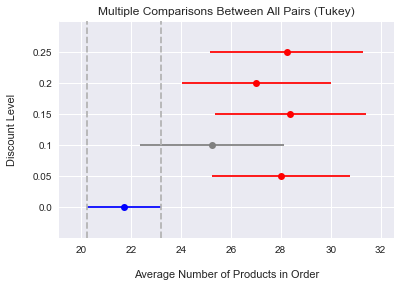

In [17]:
# let's compare all levels with 0.0 (blue)
# all groups that are significantly different from 0.0 are color coded red, all insignificant groups gray
mc_results.plot_simultaneous(comparison_name=0.0, figsize=(6,4), 
                             ylabel='Discount Level\n', xlabel='\nAverage Number of Products in Order');

--> **All discount levels significantly differ from NO DISCOUNT - except the 0.1% discount.**

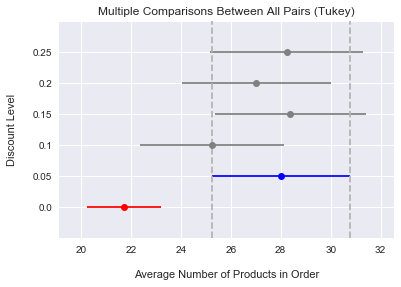

In [18]:
# let's compare all levels with 0.05 (blue)
# all groups that are significantly different are color coded red, all insignificant groups gray
mc_results.plot_simultaneous(comparison_name=0.05, figsize=(6,4),                            
                             ylabel='Discount Level\n', xlabel='\nAverage Number of Products in Order');

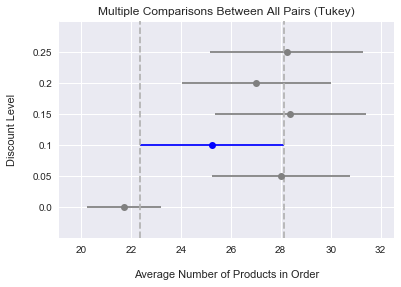

In [19]:
# let's compare all levels with 0.10 (blue)
# all groups that are significantly different are color coded red, all insignificant groups gray
mc_results.plot_simultaneous(comparison_name=0.1, figsize=(6,4), 
                             ylabel='Discount Level\n', xlabel='\nAverage Number of Products in Order');

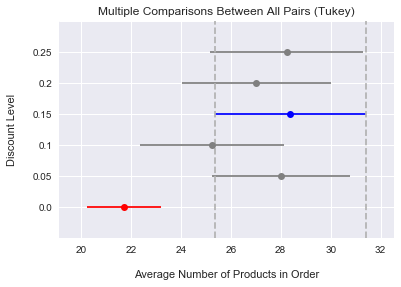

In [20]:
# let's compare all levels with 0.15 (blue)
# all groups that are significantly different are color coded red, all insignificant groups gray
mc_results.plot_simultaneous(comparison_name=0.15, figsize=(6,4), 
                             ylabel='Discount Level\n', xlabel='\nAverage Number of Products in Order');

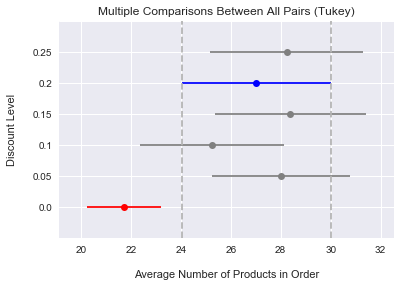

In [21]:
# let's compare all levels with 0.20 (blue)
# all groups that are significantly different are color coded red, all insignificant groups gray
mc_results.plot_simultaneous(comparison_name=0.2, figsize=(6,4), 
                             ylabel='Discount Level\n', xlabel='\nAverage Number of Products in Order');

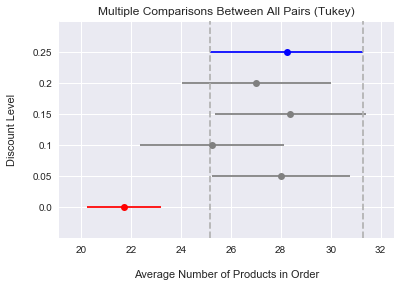

In [22]:
# let's compare all levels with 0.25 (blue)
# all groups that are significantly different are color coded red, all insignificant groups gray
mc_results.plot_simultaneous(comparison_name=0.25, figsize=(6,4), 
                             ylabel='Discount Level\n', xlabel='\nAverage Number of Products in Order');

--> **However, some levels seem to have an unwanted effect, e.g. 0.2: The number of ordered products becomes even less compared to 0.15 or 0.05!**

### 3.4 - Conclusions

**A one-way ANOVA with $\alpha$ = 0.05 was used to analyze the effect of discount levels on the number of items in an order:**

* There was a **statistically significant difference** between the discount levels with p = 2.991487e-09.

* Therefore I may reject the null hypothesis in support of the alternative: The average number of ordered products differs between at least two discount levels. It seems that the number of items can't be increased by offering a discount higher than 0.05.

* Post-hoc testing revealed interesting details though in which groups actually differ. Further investigation may be needed, but post-hoc testing revealed interesting details about which groups actually differ. For example, there is some evidence that a discount of 0.1 may be less productive than one of 0.15 or 0.25 (double-digits).

* However, the effect size is small, pointing to a **low practical significance**.

* My $\alpha$ = 0.05 is effectively the probability that I might mistakenly reject the null hypothesis when it is actually true. This is called a "Type 1 Error". <br> With a significance level set to 5%, I am saying that only a small probability of a Type 1 error occurring is acceptable. The opposite is a "Type 2 Error" where I may mistakenly support the null hypothesis when the alternative is actually true.

**The results could be used to further investigate and maybe test the effect of different discount levels as potential revenue boosters.**